In [23]:
from dotenv import load_dotenv
import os
import time
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
from Preprocessing.preprocessing_pipeline_final import preprocessing_pipeline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

load_dotenv()  # lädt .env automatisch
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")



In [2]:
pd.set_option("display.max_columns", None)

In [9]:
def call_llm(text):
    # Diese Funktion nutzt die API von Google um sich gegen das LLM zu schalten. Prompt etc. ist unten zu sehen

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                '''Du bist ein Experte für Automobilklassifikation. Deine Aufgabe ist es, Automodelle basierend auf ihrem Namen einem von fünf vordefinierten Fahrzeugsegmenten zuzuordnen. Bitte gib nur den Namen des passenden Segments zurück.

                    Die Segmente sind:

                    1. Kleinwagen – kleine Stadtautos, z.B. VW Up!, Renault Clio, Fiat Panda
                    2. Mittelklasse – normale Alltagsautos, z.B. VW Golf, Audi A4, BMW 3er
                    3. Geländewagen – große Fahrzeuge mit viel Platz, z.B. BMW X3, VW Tiguan, Ford Kuga, VW Multivan
                    4. Sportwagen – sportliche Fahrzeuge mit viel PS, z.B. Porsche 911, Audi R8, BMW M4
                    5. Luxusklasse – hochwertige Fahrzeuge mit Premiumausstattung, z.B. BMW 7er, Mercedes S-Klasse, Tesla Model S

                    Beispiele:
                    
                    Input: smart forTwo
                    Output: Kleinwagen

                    Input: Volkswagen Golf  
                    Output: Mittelklasse

                    Input: BMW X5  
                    Output: Geländewagen

                    Input: Porsche 911  
                    Output: Sportwagen

                    Input: Bentley Mulsanne
                    Output: Luxusklasse

                Gib mir als Output nur das Fahrzeugsegment aus.                             
                ''',
            ),
            ("human", "{input}"),
        ]
    )

    chain = prompt | llm
    res = chain.invoke(
        {
            "input": text
        }
    )

    return res.content

'''
def use_llm_on_model(model_list):
    # Diese Funktion ruft die call_llm Funktion auf, um der Spalte model das Fahrzeugsegment zuzuordnen

    result = {}
    counter = 0
    limit_per_minute = 15 # brauchen diesen Timer um nicht zu viele Anfragen zu stellen (free sind 15 Anfragen/Min)

    for idx, model in enumerate(model_list, start=1):
        result[model] = call_llm(model)
        counter += 1

        # Warten, wenn das Limit erreicht ist
        if counter % limit_per_minute == 0:
            print(f"{counter} Anfragen gestellt – warte 60 Sekunden, um Rate Limit einzuhalten...")
            time.sleep(60)

    print("Fertig!")
    return result
'''
def use_llm_on_model(model_list):
    # Diese Funktion ruft die call_llm Funktion auf, um der Spalte model das Fahrzeugsegment zuzuordnen

    result = {}

    for model in (model_list):
        result[model] = call_llm(model)

    return result

In [10]:
import concurrent.futures

def use_llm_on_model_parallel(model_list, max_workers=5):
    result = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {executor.submit(call_llm, model): model for model in model_list}
        
        for future in concurrent.futures.as_completed(future_to_model):
            model = future_to_model[future]
            try:
                result[model] = future.result()
            except Exception as e:
                result[model] = f"Error: {e}"

    return result

In [24]:
X_train, X_test, y_train, y_test , X,y, categorical_features , numeric_features = preprocessing_pipeline()

In [25]:
df = pd.concat([X, y], axis=1)

In [26]:
df.columns

Index(['brand', 'model', 'color', 'year', 'power_kw', 'power_ps',
       'transmission_type', 'fuel_type', 'fuel_consumption_l_100km',
       'fuel_consumption_g_km', 'mileage_in_km', 'offer_description',
       'registration_month', 'registration_year', 'offer_description_cleaned',
       'has_acc', 'has_additional_motortechnology', 'has_all_wheel_drive',
       'has_assistence_systems', 'has_dab_radio',
       'has_diesel_particel_feature', 'has_doubleclutch_transmission',
       'has_heated_seats', 'has_leather_interior', 'has_navigation',
       'has_panoramic_roof', 'has_sport_features', 'has_trailer_hitch',
       'has_tuev', 'is_cabrio', 'is_combi', 'is_coupe', 'price_in_euro'],
      dtype='object')

In [13]:
model_list = df['model'].unique().tolist()
result = use_llm_on_model_parallel(model_list)
df["segment"] = df["model"].map(result).fillna("unknown")

In [14]:
df

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
322,alfa-romeo,Alfa Romeo Giulietta,grey,2010,125.0,170.0,Manual,Petrol,6.4,134.0,163870.0,Turismo 1.4 TB 16V MultiAir Navi-Leder,9,2010,turismo tb v multiair navileder,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,8970,Mittelklasse
323,alfa-romeo,Alfa Romeo Giulietta,grey,2010,125.0,170.0,Manual,Petrol,6.4,134.0,117000.0,Turismo (191),12,2010,turismo,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6500,Mittelklasse
325,alfa-romeo,Alfa Romeo Giulietta,red,2010,125.0,170.0,Manual,Diesel,4.9,130.0,164940.0,Turismo/So+Wi.R/KLIMAAUT,11,2010,turismosowirklimaaut,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,7990,Mittelklasse
326,alfa-romeo,Alfa Romeo Giulietta,red,2010,88.0,120.0,Manual,Petrol,6.6,156.0,147866.0,Turismo (191),11,2010,turismo,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6900,Mittelklasse
330,alfa-romeo,Alfa Romeo Giulietta,black,2010,88.0,120.0,Manual,Petrol,6.6,156.0,143500.0,Giulietta Turismo 1.4Bi- Xenon Tempomat 1.Hand,8,2010,giulietta turismo bi xenon tempomat hand,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6650,Mittelklasse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222885,toyota,Toyota Aygo X,beige,2023,53.0,72.0,Manual,Petrol,4.9,111.0,15.0,"Aygo X 1.0 ""Style Air""",6,2023,aygo x style air,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,18990,Kleinwagen
222888,toyota,Toyota Proace,grey,2023,130.0,177.0,Automatic,Diesel,5.0,133.0,50.0,Toyota Proace 2.0 L,6,2023,toyota proace l,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,53925,Geländewagen
222889,toyota,Toyota Aygo,red,2023,53.0,72.0,Automatic,Petrol,4.8,109.0,15.0,"Aygo X 1.0 ""Pulse"" mit Automatikgetriebe",6,2023,aygo x pulse mit automatikgetriebe,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,18290,Kleinwagen
222892,volkswagen,Volkswagen T6 California,yellow,2019,110.0,150.0,Manual,Diesel,7.1,185.0,94800.0,"T6 2.0 TDI MIXTO 4 SITZE LANG,LEDER,LED,STANDHZ",11,2019,t tdi mixto sitze langlederledstandhz,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,30880,Geländewagen


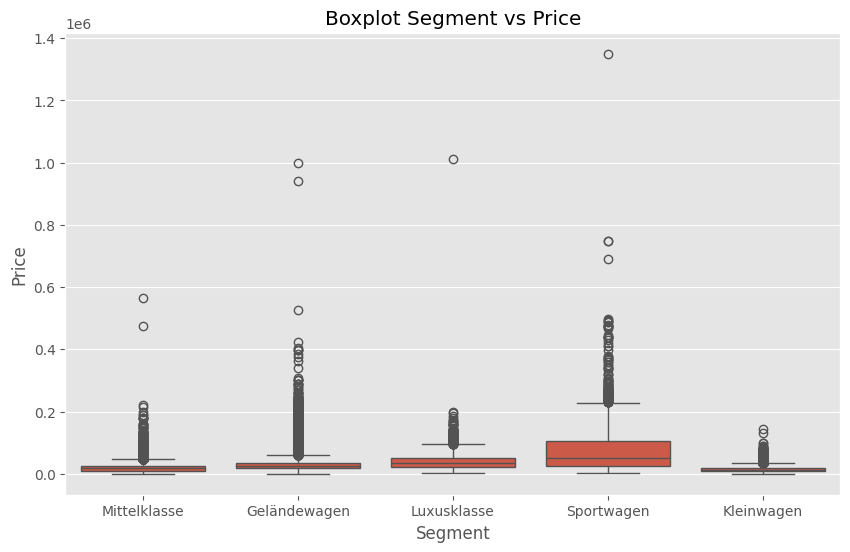

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='segment', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Segment")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

In [19]:
df[df['segment'] == 'Sportwagen'].sort_values(by = 'price_in_euro', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
149128,porsche,Porsche 991,white,2015,316.0,430.0,Automatic,Petrol,8.9,207.0,27000.0,Carrera GTS Cabrio nur 27.000km Komfortpaket,1,2015,carrera gts cabrio nur km komfortpaket,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1350000,Sportwagen
150405,porsche,Porsche 991,silver,2018,695.0,945.0,Automatic,Petrol,11.8,269.0,9858.0,MANHART TR 900 (991.2 GT2 RS) / 945 PS / 1070 NM,7,2018,manhart tr gt rs ps nm,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,749000,Sportwagen
150401,porsche,Porsche 911,silver,2018,695.0,945.0,Automatic,Petrol,11.8,269.0,9858.0,991.2 GT2 RS Weissach,7,2018,gt rs weissach,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,749000,Sportwagen
149997,porsche,Porsche 911,blue,2018,515.0,700.0,Automatic,Petrol,11.8,269.0,133.0,GT2 RS Weissach no OPF,10,2018,gt rs weissach no opf,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,689000,Sportwagen
150161,porsche,Porsche 991,grey,2018,515.0,700.0,Automatic,Petrol,11.8,269.0,9018.0,911 991 GT2 RS Clubsport Weissach Grigio Telesto,9,2018,gt rs clubsport weissach grigio telesto,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,499000,Sportwagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91465,mercedes-benz,Mercedes-Benz SLK 200,black,2001,120.0,163.0,Manual,Petrol,9.5,228.0,199000.0,Kompressor,7,2001,kompressor,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2300,Sportwagen
2246,audi,Audi RS6,black,2004,353.0,480.0,Automatic,Petrol,14.6,350.0,142000.0,RS 6 Avant plus,4,2004,rs avant plus,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1999,Sportwagen
91045,mercedes-benz,Mercedes-Benz SLK 200,silver,1999,100.0,136.0,Manual,Petrol,9.1,217.0,219000.0,-Leder-Klima,1,1999,lederklima,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,1950,Sportwagen
91186,mercedes-benz,Mercedes-Benz SLK 200,black,2000,100.0,136.0,Manual,Petrol,9.1,217.0,200106.0,SLK 200 Leder Alu Klima D4 Tüv 05/2023 2.Hand,3,2000,slk leder alu klima d tüv hand,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,1700,Sportwagen


In [ ]:
df.to_csv('df_mit_segment.csv', index=False)